Berner Fachhochschule BFH - MAS Data Science - Graph Machine Learning - Master Thesis FS/2022 Thomas Iten

# 14. Graph SAGE Link Prediction

**Inhalt**
1. Cora Daten laden
2. Test- und Trainingsdaten aufbereiten
3. Node Features hinzufügen
4. Link Generator definieren
5. Model erstellen
6. Model trainieren
7. Test Performance

**Referenzen**<br />
[1] http://snap.stanford.edu/graphsage/<br />
[2] https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/graphsage-link-prediction.html<br />
[3] Stamile, Marzullo, Deusebio. Graph Machine Learning. Packt Publishing 2021. ISBN 978-1-80020-449-2


In [1]:
import numpy as np

from tensorflow import keras
from sklearn import metrics

import networkx as nx
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification

from gml.graph.graph_builder import GraphBuilder

## 14.1 Cora Daten laden

Der Cora-Datensatz besteht aus 2708 wissenschaftlichen Veröffentlichungen, die einer von sieben Klassen zugeordnet sind. Das Zitationsnetzwerk besteht aus 5278 Links. Jede Veröffentlichung im Datensatz wird durch einen Wortvektor mit 0/1-Werten beschrieben, der das Fehlen/Vorhandensein des entsprechenden Wortes aus dem Wörterbuch angibt. Das Wörterbuch besteht aus 1433 eindeutigen Wörtern.

Die Datei cora.cites enthält die Liste aller Verbindungen, mit jeweils einem Knotenpaar pro Zeile:
```
35    1033
3229  118559
...
```
Die Liste wird mit Hilfe der GraphBuilder Klasse geladen. Die Builder Klasse erstellt neben der Edge List automatisch die Liste aller Knoten. Anschliessend wird mit der create() Methode der Graph erstellt und order und size ausgegeben.



In [2]:
cora_edges_file = "../data/cora/cora.cites"

graph = GraphBuilder().append_edges_file(cora_edges_file, sep="\t").create(detect_multi_graph=False)
props = graph.properties()

print("Graph order and size:")
print("Order =", props['order'], "(number of nodes)")
print("Size  =", props['size'], "(number of edges)")

Graph order and size:
Order = 2708 (number of nodes)
Size  = 5278 (number of edges)


## 14.2 Test- und Trainigsdaten aufbereiten
Für die Aufteilung der Daten wird die Klasse EdgeSplitter aus dem stellargraph.data Package verwendent. Für die Node Features wird eine Identity Matrix erstellt und pro Node wird der korrespondierende Vektor zugewiesen.

**Testdaten**

Als erstes werden aus dem gesammten Graphen einen Teilgraphen sowie eine Liste von Verbindungen und Labels für die Tests generiert.
- test_graph   : Subset von original Graphen mit allen Knoten aber nur einem Teil der Verbindungen
- test_samples : Liste mit Knotenpaaren mit realen Verbindungen (positive edges) und Knotenpaaren die keine Verbindungen haben (negative edges)
- test_labels  : Liste mit den Labeln passend zu den Knotenpaaren der Testdaten

In [3]:
edgeSplitter = EdgeSplitter(graph.graph)
test_graph, test_samples, test_labels  = edgeSplitter.train_test_split(p=0.1, method="global", keep_connected=True)

** Sampled 527 positive and 527 negative edges. **


**Trainingsdaten**

Das gleich wird anschliessend für die Trainingsdaten gemacht. Bei der Initialisierung der EdgeSplitter Klassen wird zusätzlich der erstellte test_graph übergeben, so dass die Trainings- und Testdaten nicht überschneiden.

In [4]:
edgeSplitter = EdgeSplitter(test_graph, graph.graph)
train_graph, train_samples, train_labels = edgeSplitter.train_test_split(p=0.1, method="global", keep_connected=True)

** Sampled 475 positive and 475 negative edges. **


## 14.3 Node Features hinzufügen
Graph SAGE verwendet Node Features für das Lernen. In diesem Beispiel verwenden wir dazu eine Identity Matrix in der Grösse der Anzahl Nodes pro Datenset. Jedem Node wird anschliessend der korrespondierende Vektor zugewiesen. Dieser hat in der Zelle des entsprechenden Nodes den Wert 1, alle anderen Zellen haben den Wert 0.

In [5]:
node_features="idm"
eye = np.eye(test_graph.number_of_nodes())                      # Identiy matrix (idm) with size = number of nodes
idm = {n:eye[i] for i,n in enumerate(test_graph.nodes())}       # Dictionary with node number as key and corresponding idm row as value
nx.set_node_attributes(test_graph, idm, node_features)          # Assign node features (with name 'idm') to the test_graph nodes

In [6]:
eye = np.eye(train_graph.number_of_nodes())
idm = {n:eye[i] for i,n in enumerate(train_graph.nodes())}
nx.set_node_attributes(train_graph, idm, node_features)

## 14.4 Link Generator definieren
Mit Hilfe des GraphSageLinkGenerator wird für die Trainigs- und Testdaten je ein Flow Objekt erzeugt. Diese liefert die Knoten Paarweise und wird  für das Model Training und die Vorhersagen verwendet.

Die num_samples Liste gibt die Anzahl der zu entnehmenden Nachbarknotenproben pro GraphSAGE-Schicht (hop) an. Wir haben zwei Schichten à jeweils 4 Proben. Die batch_size definiert die Anzahl Links welche pro Batch verarbeitet werden sollen.

In [7]:
batch_size = 64
num_samples = [4, 4]

train_sg   = StellarGraph.from_networkx(train_graph, node_features=node_features)
train_gen  = GraphSAGELinkGenerator(train_sg, batch_size, num_samples)
train_flow = train_gen.flow(train_samples, train_labels, shuffle=True, seed=24)

test_sg    = StellarGraph.from_networkx(test_graph, node_features=node_features)
test_gen   = GraphSAGELinkGenerator(test_sg, batch_size, num_samples)
test_flow  = test_gen.flow(test_samples, test_labels, seed=24)

## 14.5 Model erstellen

Nun erstellen wir ein GraphSAGE Modell mit zwei versteckten Schichten der Größe 20, einem Bias-Term und einer Dropout-Schicht zur Reduzierung von Overfitting. Diese wird mit einer Link Klassifizierungschicht verknüpft. Die Edge Embedding Methode 'ip' steht für Inner Product (es sind auch noch andere wie Hadamard, L1, L2 oder Avg möglich). Damit wird schliesslich ein vollständiges Keras Model mit einen Adam Optimierer erzeugt. Als Loss Funktion wird MSE (mean squared error) eingesetzt.

In [8]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes,
    generator=train_gen,
    bias=True,
    dropout=0.3)

x_inp, x_out = graphsage.in_out_tensors()
prediction   = link_classification(output_dim=1, output_act="sigmoid", edge_embedding_method="ip")(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


## 14.6 Model trainieren

Nun wird das Modell mit den Testdaten (test_flow) mit der angegebenen Anzahl Epochen trainiert.

In [9]:
epochs = 24
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

Epoch 1/24
15/15 [==============================] - 3s 134ms/step - loss: 0.2514 - acc: 0.5326 - val_loss: 0.2477 - val_acc: 0.5522
Epoch 2/24
15/15 [==============================] - 2s 112ms/step - loss: 0.2419 - acc: 0.5547 - val_loss: 0.2463 - val_acc: 0.5446
Epoch 3/24
15/15 [==============================] - 2s 110ms/step - loss: 0.2334 - acc: 0.6084 - val_loss: 0.2424 - val_acc: 0.5569
Epoch 4/24
15/15 [==============================] - 2s 112ms/step - loss: 0.2221 - acc: 0.6716 - val_loss: 0.2411 - val_acc: 0.5664
Epoch 5/24
15/15 [==============================] - 2s 114ms/step - loss: 0.2164 - acc: 0.6958 - val_loss: 0.2375 - val_acc: 0.5712
Epoch 6/24
15/15 [==============================] - 2s 113ms/step - loss: 0.2048 - acc: 0.7695 - val_loss: 0.2358 - val_acc: 0.5892
Epoch 7/24
15/15 [==============================] - 2s 111ms/step - loss: 0.1976 - acc: 0.7937 - val_loss: 0.2381 - val_acc: 0.5569
Epoch 8/24
15/15 [==============================] - 2s 108ms/step - loss: 0.

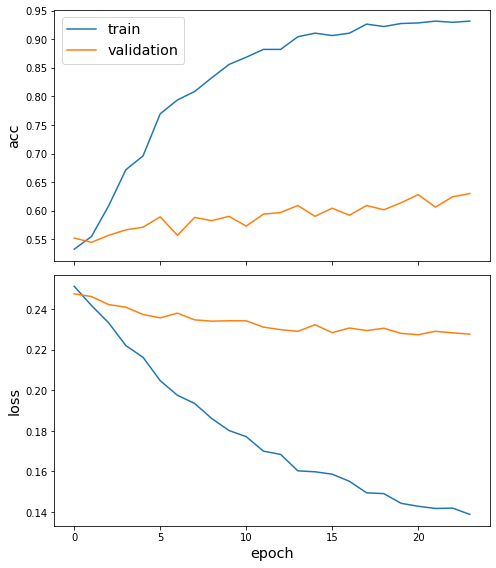

In [10]:
sg.utils.plot_history(history)

## 14.7 Test Performance
Nun kann das trainierte Modell für die Vorhersagen genutzt werden. Dazu messen wir die Performance der Trainings- und Testdaten.

In [11]:
def evaluate_metrics(title, labels, y_pred):
    print(title)
    print("- Precision =", metrics.precision_score(labels, y_pred))
    print("- Recall    =", metrics.recall_score(labels, y_pred))
    print("- F1-Score  =", metrics.f1_score(labels, y_pred))
    print()

y_pred = np.round(model.predict(train_flow)).flatten()
evaluate_metrics("Performance Training Set:", train_labels, y_pred)

y_pred = np.round(model.predict(test_flow)).flatten()
evaluate_metrics("Performance Test Set:", test_labels, y_pred)

Performance Training Set:
- Precision = 0.5191146881287726
- Recall    = 0.5431578947368421
- F1-Score  = 0.5308641975308642

Performance Test Set:
- Precision = 0.5905006418485238
- Recall    = 0.872865275142315
- F1-Score  = 0.7044410413476264



---
_The end._